### SEGMENT ANYTHING USING 3-bands reduced from time stack. 

Import a raster generated by feature engineering on a timestack of Sentinel data. Then apply SAMGeo to it.

Note, this might need to be run in a different python environment to everything else in this pipeline.. 

Inputs:
- A stub name (or file name) of a 3-band geotif. 

Params:
- So far, using default params for SAMGeo works well.
- provide a threshold for filtering polygons by area and perim:area, to remove non-paddocks. 

Outputs:
- outdir+stub+'.gpkg'
- outdir+stub+'_filt.gpkg' -- This provides input for paddock time series analysis. 


In [1]:
import os
import leafmap # pip install leafmap
#from samgeo import SamGeo, tms_to_geotiff, get_basemaps # pip install segment-geospatial

In [3]:
stub = 'GRANT'
outdir = "/g/data/xe2/John/Data/PadSeg/"

model_path = "/g/data/xe2/John/Data/PadSeg/" # This points to the pretrained SAM model # https://github.com/facebookresearch/segment-anything#model-checkpoints


In [3]:
import os
#image = "/g/data/xe2/John/Data/MILG_output2.tif"
image = "/g/data/xe2/John/Data/PadSeg/"+stub+".tif"
os.path.exists(image)

True

In [5]:
os.path.join(outdir, 'sam_vit_h_4b8939.pth')

'/g/data/xe2/John/Data/PadSeg/sam_vit_h_4b8939.pth'

In [4]:
chpt = os.path.join(model_path, 'sam_vit_h_4b8939.pth')

from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint=chpt)


ModuleNotFoundError: No module named 'segment_anything'

In [14]:
# block depends on checkpoint being downlaoded and ititilizd (see above)

chpt = os.path.join(outdir, 'sam_vit_h_4b8939.pth')

sam = SamGeo(
    model_type="vit_h",
    checkpoint=chpt,
    sam_kwargs=None,
)

# eg. https://samgeo.gishub.org/usage/

In [15]:
# segment the image
image = image

mask = outdir+stub+'_segment.tif'
sam.generate(
    image, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

# erosion_kernel seems to provide an internal buffer in polygons. 
# for a 0.05 (10km) Sentinel-2 based image, takes about 45 min on CPU. Much faster (about 1min) on GPU



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:09<00:29,  9.69s/it]

 50%|█████     | 2/4 [00:12<00:10,  5.40s/it]

 75%|███████▌  | 3/4 [00:14<00:04,  4.22s/it]

100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


BoundingBox(left=13927880.0, bottom=-4331740.0, right=13937540.0, top=-4321380.0)
(518, 483)


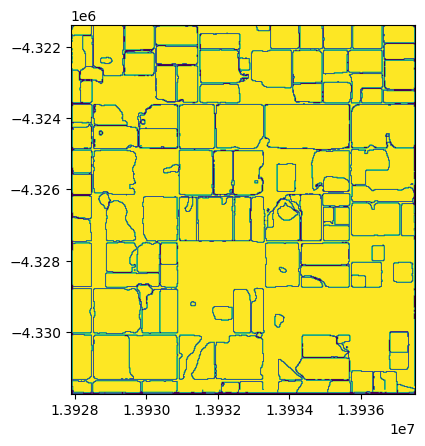

<Axes: >

In [16]:
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

m = rio.open(mask)

print(m.bounds)
print(m.shape)

#plt.imshow(m1)

show(m)

In [28]:
# m = leafmap.Map(center=[-34.388926475060956, 148.4697315595489], zoom=14)
# m.add_basemap("SATELLITE")

# # m.layers[-1].visible = False  # turn off the basemap
# # m.add_raster(image, layer_name="Image")
# # m

AttributeError: 'NoneType' object has no attribute 'cmdline'

### Polygon:

In [17]:
# polygonize the mask raster

vector = outdir+stub+'_segment.gpkg'
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

shapefile = outdir+stub+'_segment.shp'
sam.tiff_to_vector(mask, shapefile)

In [18]:
# Visualie the polygons :

style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}

m = leafmap.Map(center=[-34.388926475060956, 148.4697315595489], zoom=14)
m.add_basemap("SATELLITE")

m.add_vector(vector, layer_name="Vector", style=style)
m

Map(center=[-34.388926475060956, 148.4697315595489], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BoundingBox(left=14323820.0, bottom=-4135900.0, right=14326720.0, top=-4132720.0)
(159, 145)
(3, 159, 145)
(159, 145, 3)


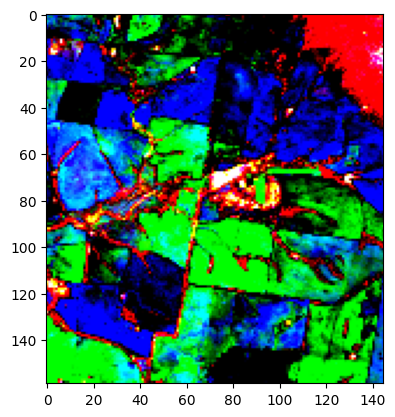

In [19]:

# image = "/g/data/xe2/John/Data/MILG_output.tif"

# m = rio.open(image)

# print(m.bounds)

# print(m.shape)

# m1 = m.read()
# print(m1.shape)

# m2 = np.rollaxis(m1, 0, 3)

# print(m2.shape)
# plt.imshow(m2)


In [19]:
show(m.read(), transform=m.transform)

AttributeError: 'Map' object has no attribute 'read'

### Read shapefile as geopandas and assign unique ID to each object, save as new shapefile

plot the paddock size distribution. Set upper and lower threshold then trim.
Save new polygons

In [20]:
import geopandas as gpd
import pandas as pd
import numpy as np


In [21]:
pol = gpd.read_file(vector).drop(labels = 'value', axis = 1)

pol['area'] = pol.area
pol['area_ha'] = pol['area']/1000
pol['log_area_ha'] = np.log10(pol['area_ha'])
pol['perim-area'] = pol.length/pol['area_ha']


type(pol['area_ha'])



pandas.core.series.Series

count      274.000000
mean       331.308029
std       1709.439440
min          0.400000
25%          1.200000
50%         13.000000
75%        369.000000
max      27816.800000
Name: area_ha, dtype: float64


<Axes: ylabel='Frequency'>

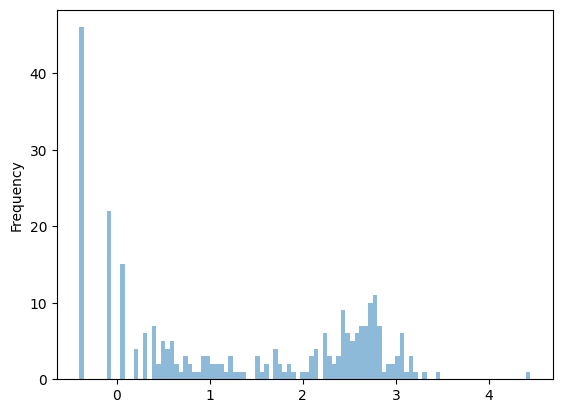

In [22]:
summary = pol['area_ha'].describe()
print(summary)

p = pol['log_area_ha'].plot.hist(bins = 100, alpha=0.5)
p

In [26]:
min_ha = 10
max_ha = 1500
max_perim_area = 30

#pol = pol.loc[pol['area_ha'] > min_ha & (df['B']>2)]

pol2 = pol[(pol['area_ha'] < max_ha) & (pol['area_ha'] > min_ha)]
pol2 = pol2[(pol['perim-area'] < max_perim_area)]
#pol2

In [27]:
## Save output as shapefile

pol2.to_file(outdir+stub+'_filt.gpkg', driver='GPKG')

<Axes: ylabel='Frequency'>

  4%|▍         | 107M/2.56G [58:39<22:27:44, 30.4kB/s]
  1%|          | 32.0M/2.56G [53:58<71:14:25, 9.87kB/s]


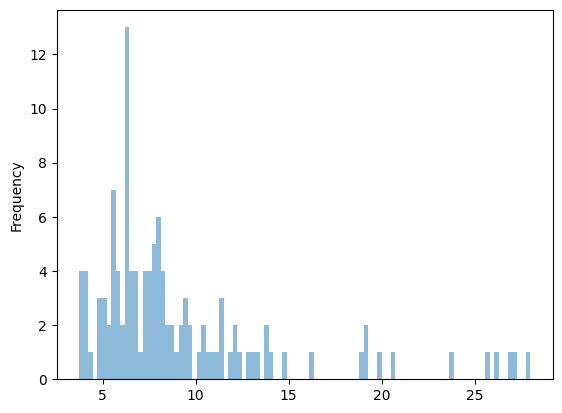

In [28]:
p = pol2['perim-area'].plot.hist(bins = 100, alpha=0.5)
p

<Axes: >

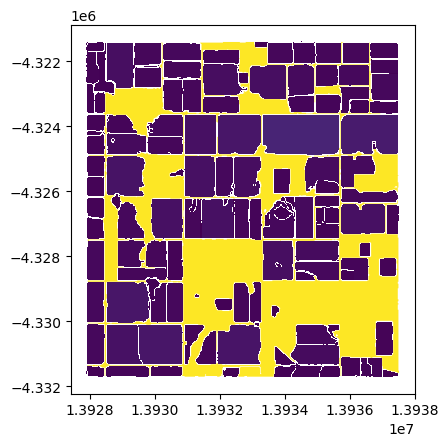

In [29]:
pol.plot(column = 'area')